In [1]:
import glob
import numpy as np
import scipy as sp
import scipy.stats
import xarray as xr
import pickle as pkl

import mne
import cmlreaders as cml
import cluster_helper.cluster
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

from constants import FR2_valid_subjects, FR2_subjects_sorted, frequencies
from plot_utils import plot_heatmap_contrast

In [2]:
def FR2_univariate_tstats(subject, task, ret_type='ci'):
    
    import os
    import glob
    import scipy.stats
    import numpy as np
    import pandas as pd
    import xarray as xr
    import pickle as pkl
    
    from constants import ROIs
    from utils import load_feature, split_ROIs, get_eeg_sys
    
    features = load_feature(subject, task_phase=task, ret_type=ret_type,
                            exclude_peripheral_channels=False, stack_feature=False)
    features = split_ROIs(features, sys=get_eeg_sys(subject))
    
    label = 'recalled' if task=='enc' else 'rec_label'
    positive_events = features.sel(events=features.events.values[label]==1)
    negative_events = features.sel(events=features.events.values[label]==0)

    tvals = scipy.stats.ttest_ind(positive_events, negative_events, axis=1).statistic # along events axis
    tvals = xr.DataArray(tvals, dims=['ROI','frequency'],
                         coords={'ROI':negative_events.ROI.values,
                                 'frequency':negative_events.frequency.values})
    
    return tvals

#### group

In [11]:
tstats = [FR2_univariate_tstats(s, task='enc', ret_type='ci') 
          for s in FR2_valid_subjects]

In [18]:
pkl.dump(tstats, open('data/univar_enc_tstats.pkl','wb'))

In [17]:
tstats = pkl.load(open('data/univar_enc_tstats.pkl','rb'))

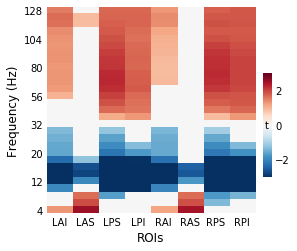

In [18]:
fig, ax = plot_heatmap_contrast([s.sel(frequency=s.frequency>2) for s in tstats], vmin=-3, vmax=3, figsize=[4.2,3.6])

In [19]:
# fig.savefig('figures_final/univar_enc.pdf')

In [7]:
tstats = [FR2_univariate_tstats(s, task='ret', ret_type='ci') 
          for s in FR2_valid_subjects]

In [9]:
pkl.dump(tstats, open('data/univar_retci_tstats.pkl','wb'))

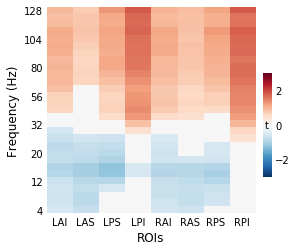

In [10]:
fig, ax = plot_heatmap_contrast([s.sel(frequency=s.frequency>2) for s in tstats], vmin=-3, vmax=3, figsize=[4.2,3.6])

In [11]:
# fig.savefig('figures_final/univar_retci.pdf')

#### individuals

In [92]:
FR2_subjects_sorted[7]

'LTP287'

In [91]:
tstats = [FR2_univariate_tstats(s, task='enc') for s in FR2_subjects_sorted]
# tstats = [FR2_univariate_tstats(s, task='ret', ret_type='ci') for s in FR2_subjects_sorted]

In [95]:
tstats[7]

<xarray.DataArray (ROI: 8, frequency: 30)>
array([[ 7.974812,  7.659676,  7.860139, ...,  7.124707,  7.264287,  6.981654],
       [10.754173, 10.484985, 10.59526 , ...,  6.039636,  6.09745 ,  6.015887],
       [ 8.878976,  7.371805,  6.794565, ...,  7.206712,  7.233709,  7.308291],
       ...,
       [ 8.080881,  7.724997,  7.699609, ...,  5.082835,  5.06824 ,  5.018248],
       [ 8.64909 ,  6.644967,  5.812781, ...,  8.099781,  8.06324 ,  7.784844],
       [ 7.687955,  6.915931,  6.647674, ...,  7.755206,  7.857821,  7.180875]],
      dtype=float32)
Coordinates:
  * ROI        (ROI) <U3 'LAS' 'LAI' 'LPS' 'LPI' 'RAS' 'RAI' 'RPS' 'RPI'
  * frequency  (frequency) float64 2.0 4.0 6.0 8.0 ... 110.0 116.0 122.0 128.0

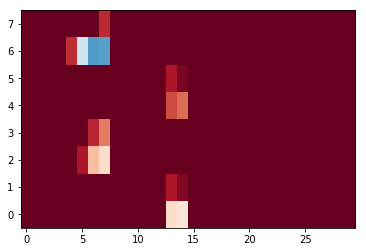

In [97]:
plt.figure()
plt.imshow(tstats[7], origin='lower', aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)

In [14]:
rows = np.array([tstats[i].sel(frequency=tstats[i].frequency>2).mean('ROI').values 
                 for i in range(len(FR2_subjects_sorted))])

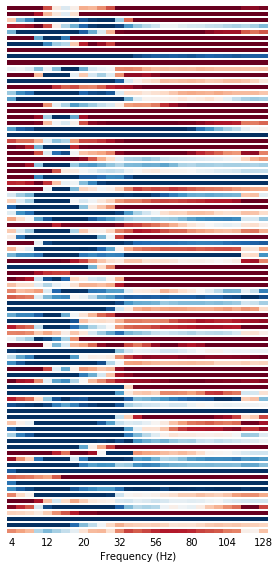

In [15]:
l = len(FR2_subjects_sorted)

fig, axes = plt.subplots(l, 1, figsize=[4, 8])

for i in range(l):
    ax = axes[i]
    ax.imshow([rows[i]], origin='lower', aspect='auto', vmin=-3, vmax=3, cmap='RdBu_r')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
i = l-1
axes[i].set_xticks(range(len(frequencies))[::4])
axes[i].set_xticklabels(['%d'%f for f in frequencies[1::4]])
axes[i].set_xlabel('Frequency (Hz)', size=10)
    
fig.tight_layout(h_pad=0.2)

In [16]:
fig.savefig('figures_final/univar_enc_id.pdf')
# fig.savefig('figures_final/univar_retci_id.pdf')